In [ ]:
import cv2
import numpy as np
from math import sqrt, log
import matplotlib.pyplot as plt

In [ ]:
image = cv2.imread('taj.jpg', 0)

In [ ]:

def generate_base_image(image, sigma, assumed_blur):
    #Upsample image by 2x and apply Gaussian blur
    image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    sigma_diff = sqrt(max(sigma ** 2 - (2 * assumed_blur) ** 2, 0.01))
    return cv2.GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)

def compute_num_octaves(image_shape):
    #Compute the number of octaves based on image shape.
    return int(log(min(image_shape)) / log(2) - 1)

def generate_gaussian_kernels(sigma, num_intervals):
    #Generate Gaussian kernels for image blurring.
    k = 2 ** (1. / num_intervals)
    kernels = [sigma] + [sqrt(k ** (2 * i) - k ** (2 * (i - 1))) * sigma for i in range(1, num_intervals + 3)]
    print("Gaussian kernels:", kernels)
    return np.array(kernels)

def generate_gaussian_images(image, num_octaves, gaussian_kernels):
    #Create a scale-space pyramid of Gaussian images.
    gaussian_images = []
    for _ in range(num_octaves):
        octave_images = [image]
        for kernel in gaussian_kernels[1:]:
            image = cv2.GaussianBlur(image, (0, 0), sigmaX=kernel, sigmaY=kernel)
            octave_images.append(image)
        gaussian_images.append(octave_images)

        # Resize the image for the next octave
        resized_image = cv2.resize(
            octave_images[-3],
            (octave_images[-3].shape[1] // 2, octave_images[-3].shape[0] // 2),
            interpolation=cv2.INTER_NEAREST
        )

        # If the original image is grayscale, ensure the resized image is also grayscale
        if len(image.shape) == 2 and len(resized_image.shape) == 3:
            resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

        image = resized_image

    # Instead of converting to a NumPy array, keep gaussian_images as a list of lists
    return gaussian_images

    return np.array(gaussian_images)

def generate_dog_images(gaussian_images):
    #Generate DoG images.
    dog_images = []
    for octave in gaussian_images:
        octave_dogs = []
        for i in range(1, len(octave)):
            dog_image = octave[i] - octave[i - 1]
            octave_dogs.append(dog_image)
        dog_images.append(octave_dogs)
    return dog_images

In [ ]:
sigma = 1.6
num_intervals = 3

Gaussian kernels: [1.6, 1.226273498465408, 1.545007793644796, 1.9465878414647133, 2.452546996930816, 3.0900155872895922]


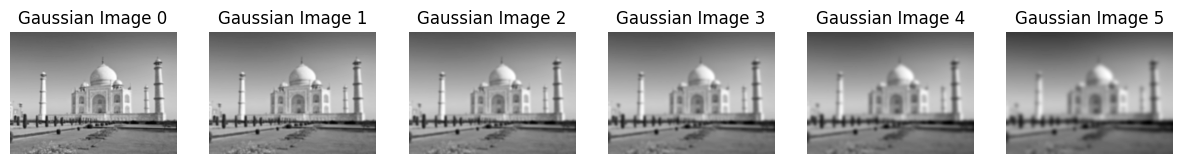

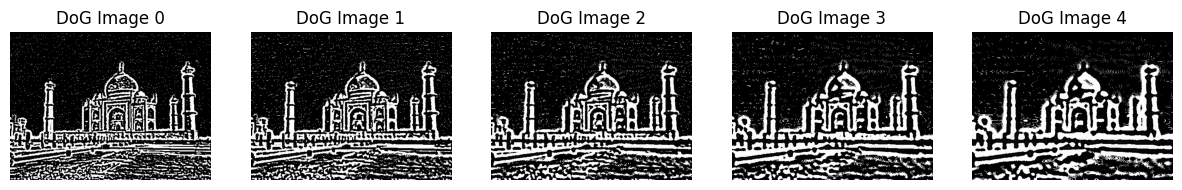

In [ ]:
# Step 1: Generate base image
base_image = generate_base_image(image, sigma, assumed_blur=0.5)

# Step 2: Compute the number of octaves
num_octaves = compute_num_octaves(base_image.shape)

# Step 3: Generate Gaussian kernels
gaussian_kernels = generate_gaussian_kernels(sigma, num_intervals)

# Step 4: Generate Gaussian images (Gaussian pyramid)
gaussian_images = generate_gaussian_images(base_image, num_octaves, gaussian_kernels)

# Step 5: Generate Difference-of-Gaussian (DoG) images
dog_images = generate_dog_images(gaussian_images)

# Plot the third layer of the Gaussian pyramid and the DoG images (index 2)
fig, axes = plt.subplots(1, len(gaussian_images[2]), figsize=(15, 5))

# Plot Gaussian images from the 3rd octave (index 2)
for i, img in enumerate(gaussian_images[2]):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Gaussian Image {i}')
    axes[i].axis('off')

plt.show()

# Plot DoG images from the 3rd octave (index 2)
fig, axes = plt.subplots(1, len(dog_images[2]), figsize=(15, 5))

for i, img in enumerate(dog_images[2]):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'DoG Image {i}')
    axes[i].axis('off')

plt.show()

In [ ]:
import numpy as np
from math import floor

def find_scale_space_extrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):
    """Find pixel positions of all scale-space extrema in the image pyramid."""
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255)  # Calculate threshold
    keypoints = []

    # Iterate over each octave
    for octave_idx, dog_octave in enumerate(dog_images):
        # Skip last two images as we need 3 consecutive DoG images
        for img_idx in range(1, len(dog_octave) - 1):
            prev_dog, curr_dog, next_dog = dog_octave[img_idx - 1:img_idx + 2]

            # Check for extrema in the middle of 3x3x3 neighborhood
            for x in range(image_border_width, curr_dog.shape[0] - image_border_width):
                for y in range(image_border_width, curr_dog.shape[1] - image_border_width):
                    if is_pixel_an_extremum(prev_dog, curr_dog, next_dog, x, y, threshold):
                        localization_result = localize_extremum_via_quadratic_fit(x, y, img_idx, octave_idx, num_intervals, dog_octave, sigma, contrast_threshold, image_border_width)
                        if localization_result:
                            keypoint, localized_img_idx = localization_result
                            keypoints_with_orientations = compute_keypoints_with_orientations(keypoint, octave_idx, gaussian_images[octave_idx][localized_img_idx])
                            keypoints.extend(keypoints_with_orientations)

    return keypoints

def is_pixel_an_extremum(prev_dog, curr_dog, next_dog, x, y, threshold):
    """Check if the pixel at (x, y) in the current DoG is a local extremum."""
    center_value = curr_dog[x, y]

    # Only consider pixels above the threshold
    if abs(center_value) <= threshold:
        return False

    # Check if the center pixel is a maximum or minimum in the 3x3x3 neighborhood
    neighborhood = np.concatenate([
        prev_dog[x-1:x+2, y-1:y+2].ravel(),
        curr_dog[x-1:x+2, y-1:y+2].ravel(),
        next_dog[x-1:x+2, y-1:y+2].ravel()
    ])

    # Remove the center pixel itself
    neighborhood = np.delete(neighborhood, 13)

    if center_value > 0:
        return np.all(center_value >= neighborhood)
    else:
        return np.all(center_value <= neighborhood)

# Placeholder for localization and orientation calculation (same as original)
def localize_extremum_via_quadratic_fit(x, y, img_idx, octave_idx, num_intervals, dog_octave, sigma, contrast_threshold, image_border_width):
    # Your localization code here
    pass

def compute_keypoints_with_orientations(keypoint, octave_idx, gaussian_image):
    # Your keypoint orientation calculation code here
    pass

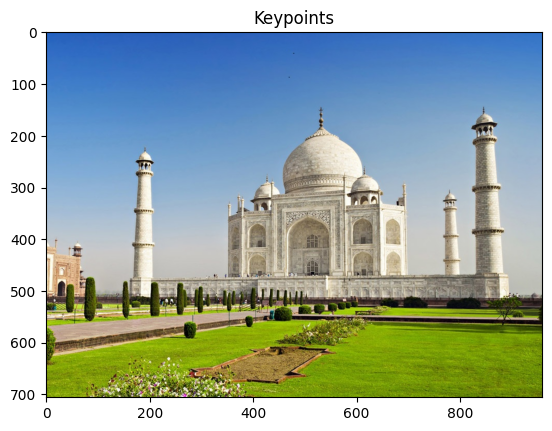

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 # Import cv2

# Function to clean keypoints (e.g., removing close keypoints)
def clean_keypoints(keypoints, threshold_dist=5):
    cleaned_kps = []
    for kp in keypoints:
        if not any(np.linalg.norm(np.array(kp.pt) - np.array(c.pt)) < threshold_dist for c in cleaned_kps):
            cleaned_kps.append(kp)
    return cleaned_kps

# Plot keypoints without using cv2
def plot_keypoints(image, keypoints):
    plt.imshow(image, cmap='gray')

    for kp in keypoints:
        x, y = kp.pt
        size = kp.size  # You can vary size based on the keypoint property
        plt.scatter(x, y, s=size, edgecolors='g', facecolors='none')

    plt.title("Keypoints")
    plt.show()

# Define the load_image function using OpenCV
def load_image(image_path):
    """Loads an image using OpenCV and converts it to RGB."""
    img = cv2.imread(image_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Example of how to use it (image_path and keypoints need to be defined)
image_path = '/content/taj.jpg'
image = load_image(image_path) # Call the defined function
cleaned_keypoints = clean_keypoints(keypoints)

# Plotting the keypoints
plot_keypoints(image, cleaned_keypoints)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor

def find_scale_space_extrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255)  # Calculate threshold
    keypoints = []

    for octave_idx, dog_octave in enumerate(dog_images):
        for img_idx in range(1, len(dog_octave) - 1):
            prev_dog, curr_dog, next_dog = dog_octave[img_idx - 1:img_idx + 2]

            for x in range(image_border_width, curr_dog.shape[0] - image_border_width):
                for y in range(image_border_width, curr_dog.shape[1] - image_border_width):
                    if is_pixel_an_extremum(prev_dog, curr_dog, next_dog, x, y, threshold):
                        localization_result = localize_extremum_via_quadratic_fit(x, y, img_idx, octave_idx, num_intervals, dog_octave, sigma, contrast_threshold, image_border_width)
                        if localization_result:
                            keypoint, localized_img_idx = localization_result
                            keypoints_with_orientations = compute_keypoints_with_orientations(keypoint, octave_idx, gaussian_images[octave_idx][localized_img_idx])
                            keypoints.extend(keypoints_with_orientations)

    print(f"Number of keypoints detected: {len(keypoints)}")  # Debug statement
    return keypoints

def is_pixel_an_extremum(prev_dog, curr_dog, next_dog, x, y, threshold):
    center_value = curr_dog[x, y]

    if abs(center_value) <= threshold:
        return False

    neighborhood = np.concatenate([
        prev_dog[x-1:x+2, y-1:y+2].ravel(),
        curr_dog[x-1:x+2, y-1:y+2].ravel(),
        next_dog[x-1:x+2, y-1:y+2].ravel()
    ])

    neighborhood = np.delete(neighborhood, 13)

    return np.all(center_value >= neighborhood) if center_value > 0 else np.all(center_value <= neighborhood)

def localize_extremum_via_quadratic_fit(x, y, img_idx, octave_idx, num_intervals, dog_octave, sigma, contrast_threshold, image_border_width):
    # Placeholder for localization code
    return (x, y), img_idx  # Assume it returns (x, y) for simplicity

def compute_keypoints_with_orientations(keypoint, octave_idx, gaussian_image):
    # Placeholder for orientation calculation
    return [keypoint]

def plot_keypoints(image, keypoints):
    """Plot the keypoints on the image."""
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    for kp in keypoints:
        plt.plot(kp[1], kp[0], 'r+', markersize=10)  # keypoints are (y, x)
    plt.title("Keypoints")
    plt.axis('off')
    plt.show()

keypoints = find_scale_space_extrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width=5)

# Check if the keypoints list is not empty
if keypoints:
    # Choose an image from gaussian_images to plot the keypoints
    plot_keypoints(gaussian_images[0][0], keypoints)  # Example plotting on the first image of the first octave
else:
    print("No keypoints to plot.")


Number of keypoints detected: 1105737
